In [121]:
import os
import glob
import random


import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image

In [93]:
learning_rate = 0.001
batch_size = 10
epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device == 'cuda':
    torch.cuda.manual_seed_all(1234)


print(device)

cpu


In [94]:
def create_dataset() -> pd.DataFrame:
    '''Create Dataset from csv files'''
    df1 = pd.read_csv("rose.csv", sep=',',
                      header=None, encoding='UTF-16')

    df2 = pd.read_csv("tulip.csv", sep=',',
                      header=None, encoding='UTF-16')
    df = pd.concat([df1, df2], ignore_index=True)
    df.drop(1, axis=1, inplace=True)
    df.rename(columns={0: 'AbsolutePath', 2: 'DatasetClass'}, inplace=True)
    return df


df = create_dataset()
print(df)

                           AbsolutePath DatasetClass
0      D:\rtfiles\dataset\rose\0001.jpg         rose
1      D:\rtfiles\dataset\rose\0002.jpg         rose
2      D:\rtfiles\dataset\rose\0003.jpg         rose
3      D:\rtfiles\dataset\rose\0004.jpg         rose
4      D:\rtfiles\dataset\rose\0005.jpg         rose
...                                 ...          ...
2035  D:\rtfiles\dataset\tulip\1016.jpg        tulip
2036  D:\rtfiles\dataset\tulip\1017.jpg        tulip
2037  D:\rtfiles\dataset\tulip\1018.jpg        tulip
2038  D:\rtfiles\dataset\tulip\1019.jpg        tulip
2039  D:\rtfiles\dataset\tulip\1020.jpg        tulip

[2040 rows x 2 columns]


In [95]:

path_test = os.path.join("D:\\", "pylab5", "test_set")
path_train = os.path.join("D:\\", "pylab5", "train_set")
path_val = os.path.join("D:\\", "pylab5", "validation_set")


def load_set(df: pd.DataFrame, path: str, number: int) -> None:
    '''Save pictures from dataset to train and validation sets'''
    image_path = df["AbsolutePath"][number]
    image = cv2.imread(image_path)
    new_path = os.path.join(path, f'{df.DatasetClass[number]}.{number}.jpg')
    cv2.imwrite(new_path, image)


def load_test_set(df: pd.DataFrame, path: str, number: int) -> None:
    '''Save pictures from dataset to test set with specific numeration'''
    image_path = df["AbsolutePath"][number]
    image = cv2.imread(image_path)
    if number - 816 > 102:
        number = number - 1734
    else:
        number = number - 816
    cv2.imwrite(os.path.join(path, f'{number}.jpg'), image)


for i in range(816):
    load_set(df, path_train, i)
for i in range(816, 918):
    load_test_set(df, path_test, i)
for i in range(918, 1020):
    load_set(df, path_val, i)
for i in range(1020, 1836):
    load_set(df, path_train, i)
for i in range(1836, 1938):
    load_test_set(df, path_test, i)
for i in range(1938, 2040):
    load_set(df, path_val, i)

In [96]:
train_list = glob.glob(os.path.join(path_train, '*.jpg'))
test_list = glob.glob(os.path.join(path_test, '*.jpg'))
train_list, val_list = train_test_split(train_list, test_size=0.1)

[720  46 132 770 247 642 625 346  71 732]


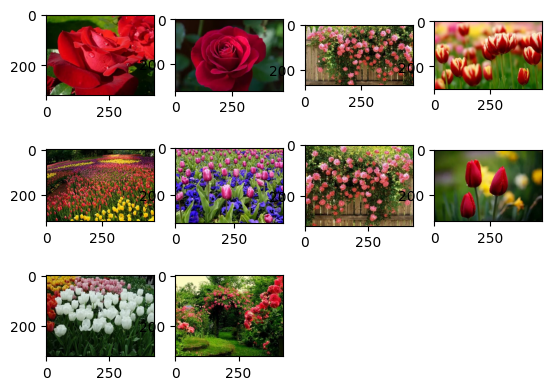

In [97]:
index = np.random.randint(1, 800, size=10)
print(index)
fig = plt.figure()
i = 1
for idx in index:
    ax = fig.add_subplot(3, 4, i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i += 1
plt.show()

In [98]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(576, 10)  # 7*7*64
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0), -1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return torch.nn.Sigmoid()(output)


model = CNN().to(device)
model.train()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [99]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [100]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None) -> None:
        '''dataset class constructur'''
        self.file_list = file_list
        self.transform = transform

    def __len__(self) -> int:
        '''get len'''
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx) -> type:
        '''function return item of dataset'''
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'rose':
            label = 1
        elif label == 'tulip':
            label = 0

        return img_transformed, label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.6967687606811523, train loss : 0.6227360963821411
Epoch : 1, val_accuracy : 0.7235294580459595, val_loss : 0.587402880191803
Epoch : 2, train accuracy : 0.7603745460510254, train loss : 0.5546382069587708
Epoch : 2, val_accuracy : 0.811764657497406, val_loss : 0.5203927159309387
Epoch : 3, train accuracy : 0.7744902968406677, train loss : 0.5293153524398804
Epoch : 3, val_accuracy : 0.8235294222831726, val_loss : 0.47682908177375793
Epoch : 4, train accuracy : 0.7908167243003845, train loss : 0.5161451101303101
Epoch : 4, val_accuracy : 0.841176450252533, val_loss : 0.4787297248840332
Epoch : 5, train accuracy : 0.8139461278915405, train loss : 0.49476829171180725
Epoch : 5, val_accuracy : 0.7911763787269592, val_loss : 0.504084050655365
Epoch : 6, train accuracy : 0.8306128978729248, train loss : 0.48201820254325867
Epoch : 6, val_accuracy : 0.8294118642807007, val_loss : 0.4974628984928131
Epoch : 7, train accuracy : 

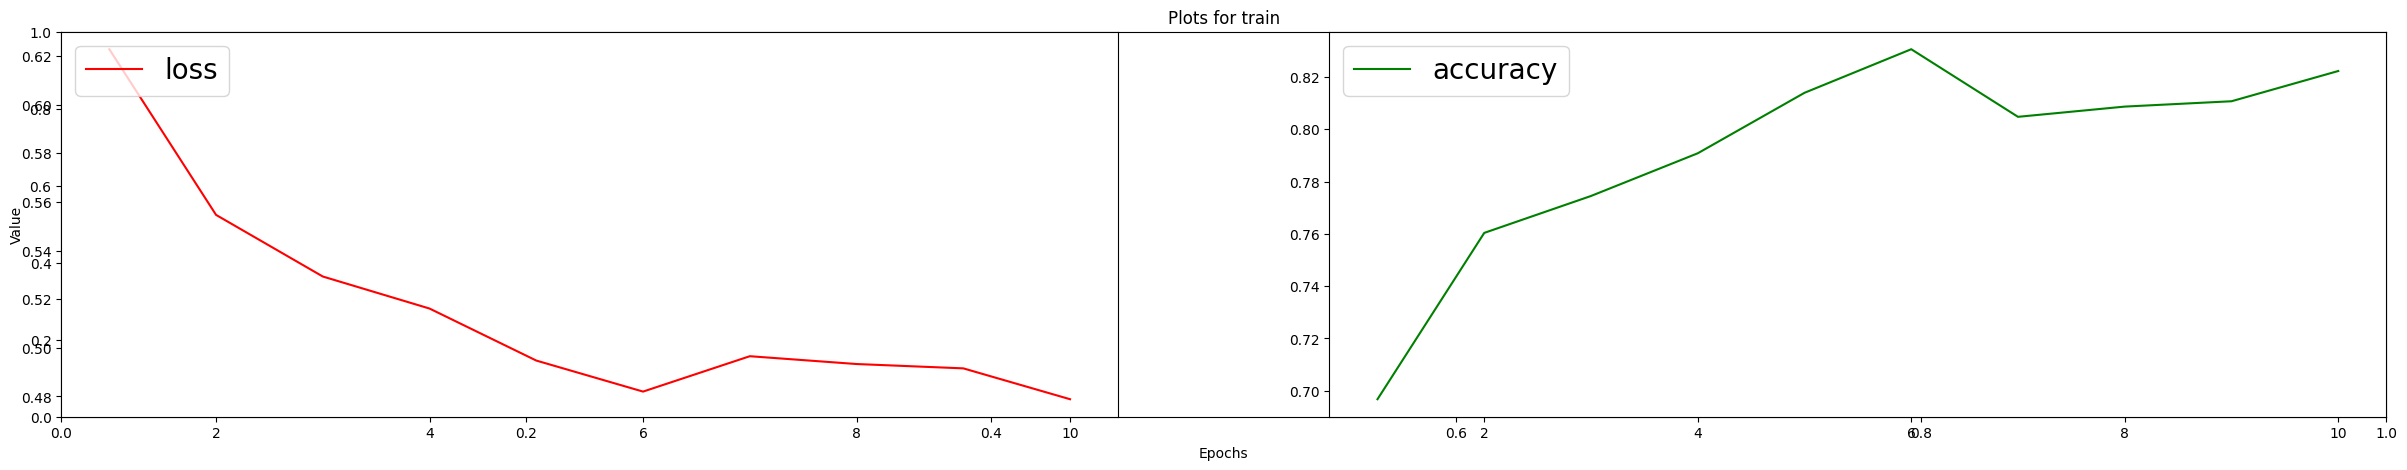

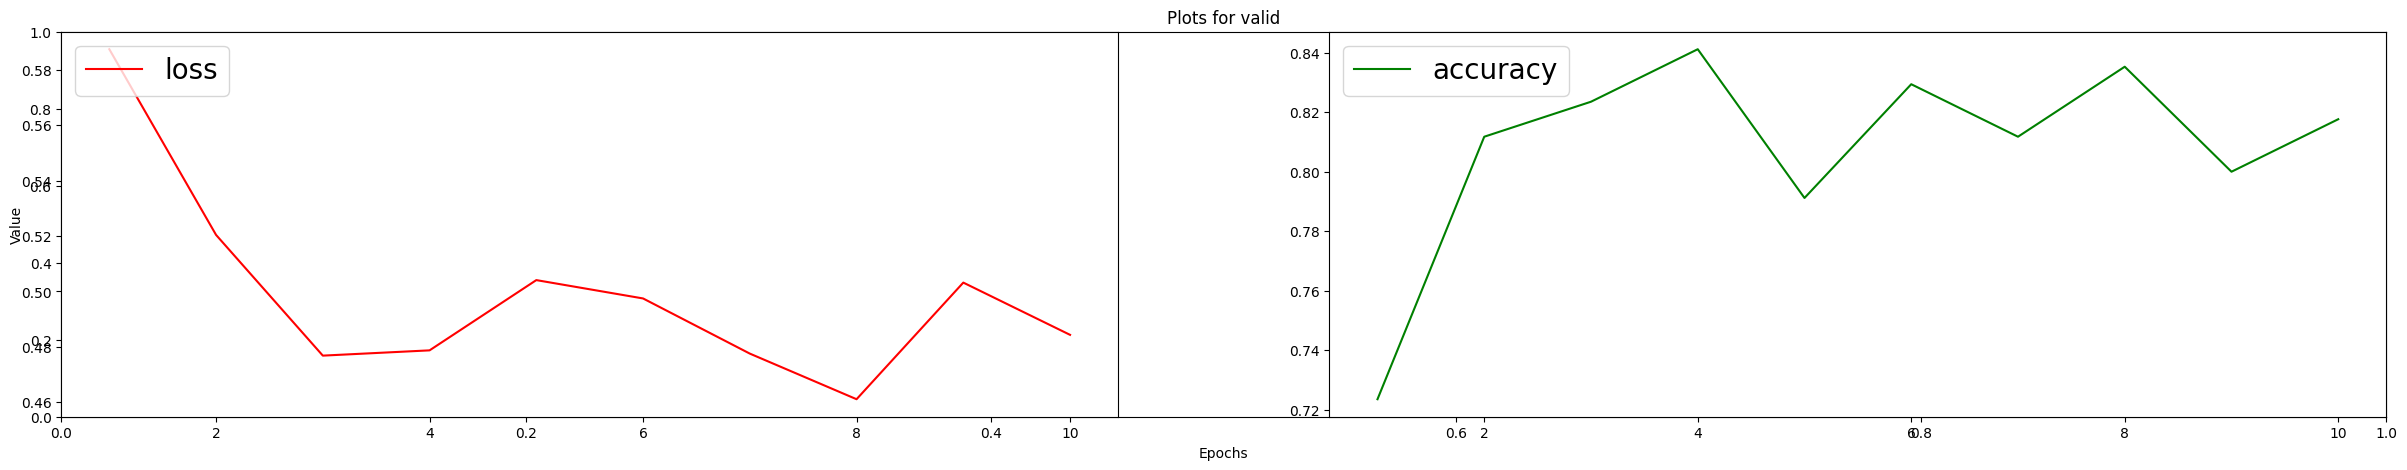

In [101]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

epochs = 10


def train_loop(train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, epochs: int) -> None:
    '''func for trainloop'''
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
            epoch+1, epoch_accuracy, epoch_loss))

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)

            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(
                epoch+1, epoch_val_accuracy, epoch_val_loss))

    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1, 2, 1)
    plt.plot(num_epochs, loss_list, color='red', label='loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1, 2, 2)
    plt.plot(num_epochs, accuracy_list, color='green', label='accuracy')
    plt.legend(loc=2, prop={'size': 20})

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1, 2, 1)
    plt.plot(num_epochs, val_loss_list, color='red', label='loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1, 2, 2)
    plt.plot(num_epochs, val_accuracy_list, color='green', label='accuracy')
    plt.legend(loc=2, prop={'size': 20})


train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.8433679342269897, train loss : 0.45900797843933105
Epoch : 1, val_accuracy : 0.8647058010101318, val_loss : 0.44645074009895325
Epoch : 2, train accuracy : 0.8515315055847168, train loss : 0.4551686942577362
Epoch : 2, val_accuracy : 0.8500000834465027, val_loss : 0.461786150932312
Epoch : 3, train accuracy : 0.8569735288619995, train loss : 0.4523768723011017
Epoch : 3, val_accuracy : 0.9058823585510254, val_loss : 0.41409364342689514
Epoch : 4, train accuracy : 0.864966869354248, train loss : 0.44441917538642883
Epoch : 4, val_accuracy : 0.8705881834030151, val_loss : 0.4451450705528259
Epoch : 5, train accuracy : 0.8493204116821289, train loss : 0.4543744921684265
Epoch : 5, val_accuracy : 0.7735294103622437, val_loss : 0.5156673192977905
Epoch : 6, train accuracy : 0.8554429411888123, train loss : 0.4501248896121979
Epoch : 6, val_accuracy : 0.8882352709770203, val_loss : 0.4257083535194397
Epoch : 7, train accurac

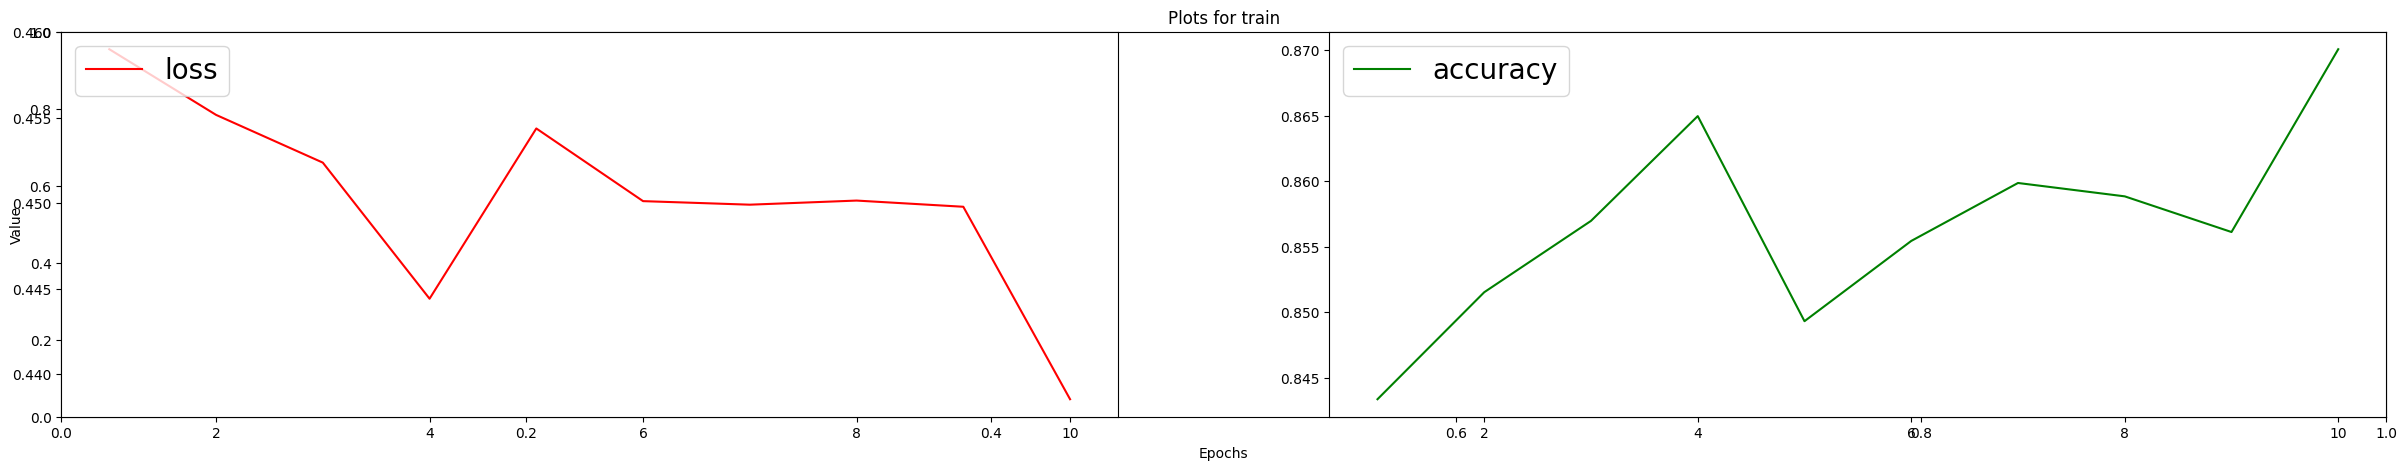

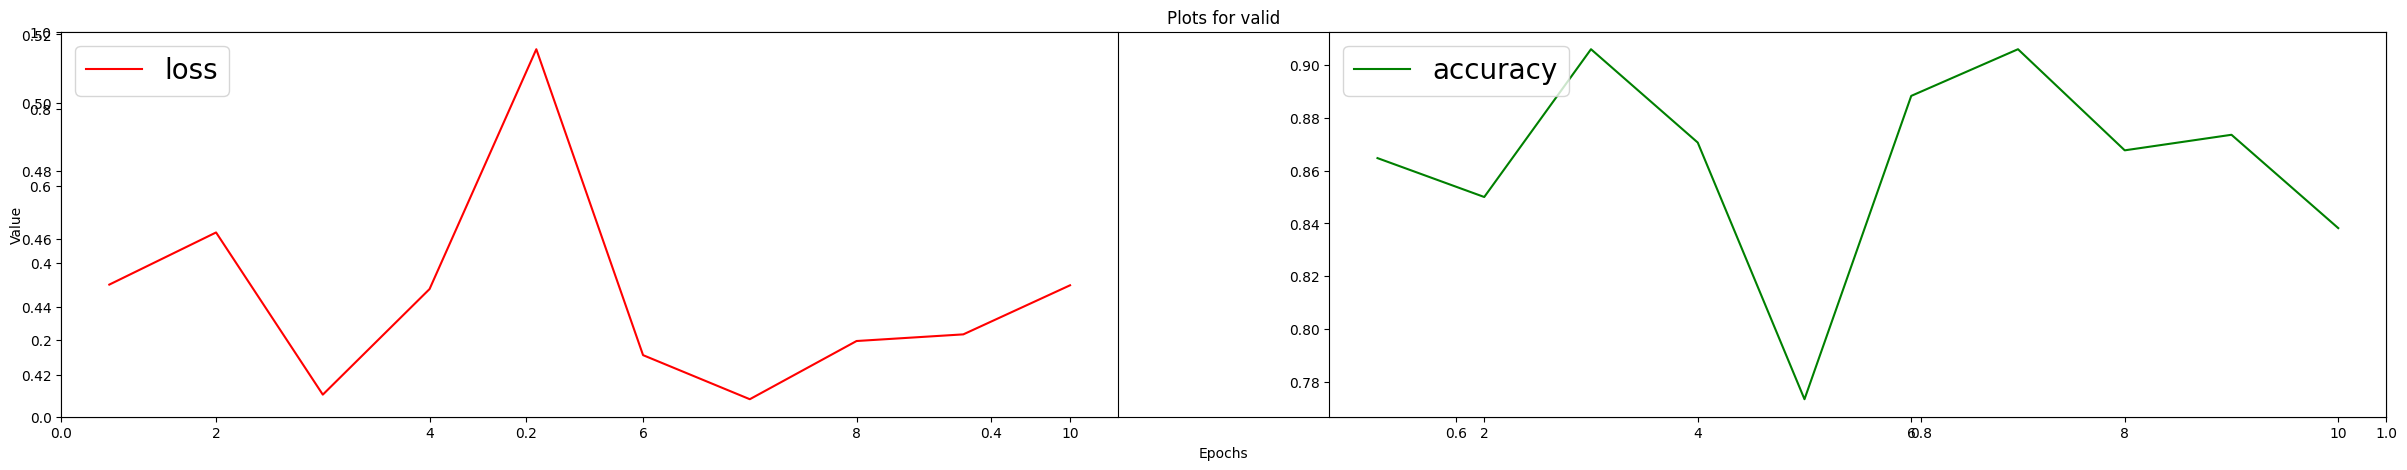

In [102]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.8508509993553162, train loss : 0.4581110179424286
Epoch : 1, val_accuracy : 0.8382352590560913, val_loss : 0.47579771280288696
Epoch : 2, train accuracy : 0.8663272857666016, train loss : 0.44247686862945557
Epoch : 2, val_accuracy : 0.8882352709770203, val_loss : 0.43077874183654785
Epoch : 3, train accuracy : 0.8481300473213196, train loss : 0.4600462019443512
Epoch : 3, val_accuracy : 0.8852941393852234, val_loss : 0.4313099682331085
Epoch : 4, train accuracy : 0.8666673898696899, train loss : 0.44557249546051025
Epoch : 4, val_accuracy : 0.8617646098136902, val_loss : 0.4440086781978607
Epoch : 5, train accuracy : 0.8617353439331055, train loss : 0.44282492995262146
Epoch : 5, val_accuracy : 0.8941175937652588, val_loss : 0.4124588370323181
Epoch : 6, train accuracy : 0.8537421226501465, train loss : 0.4509814977645874
Epoch : 6, val_accuracy : 0.8205882906913757, val_loss : 0.47431087493896484
Epoch : 7, train acc

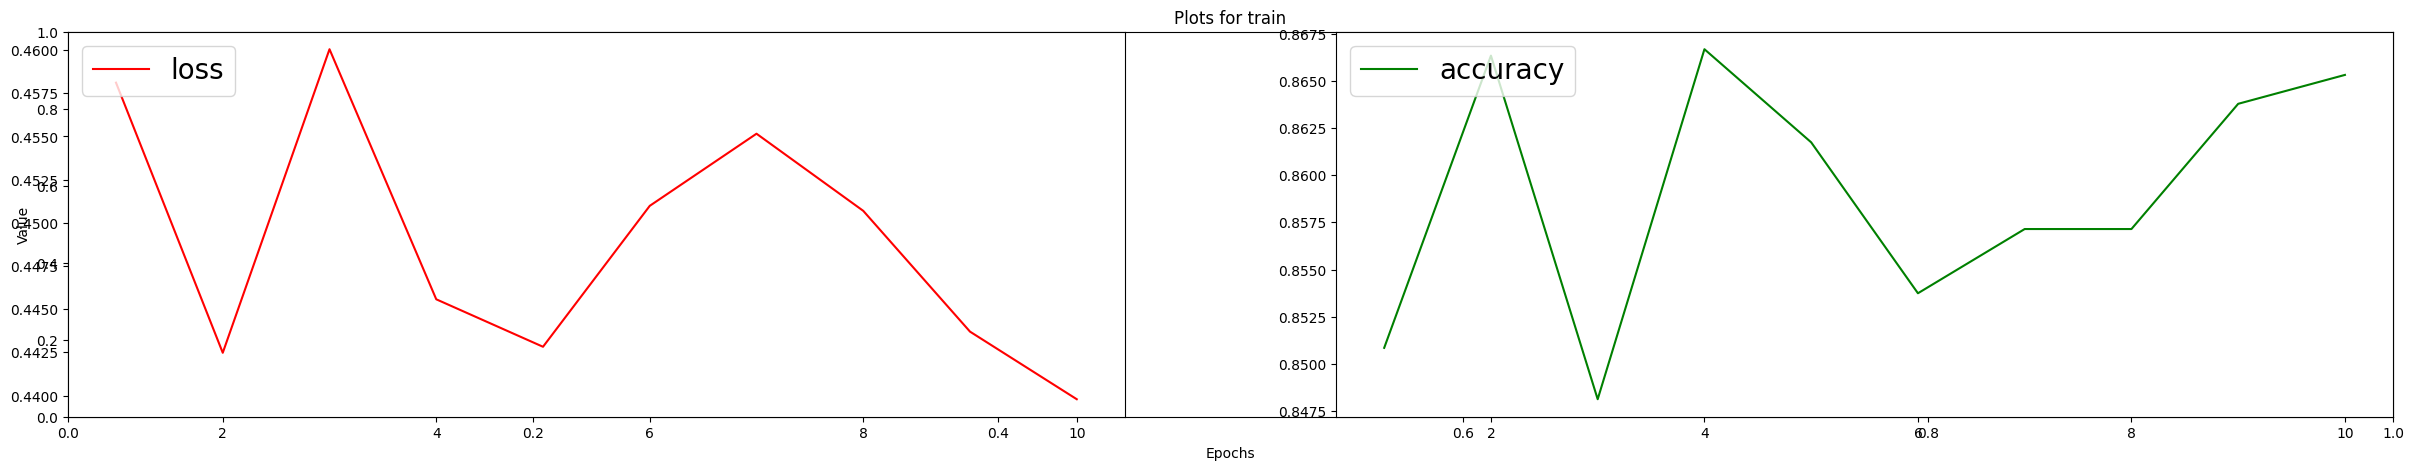

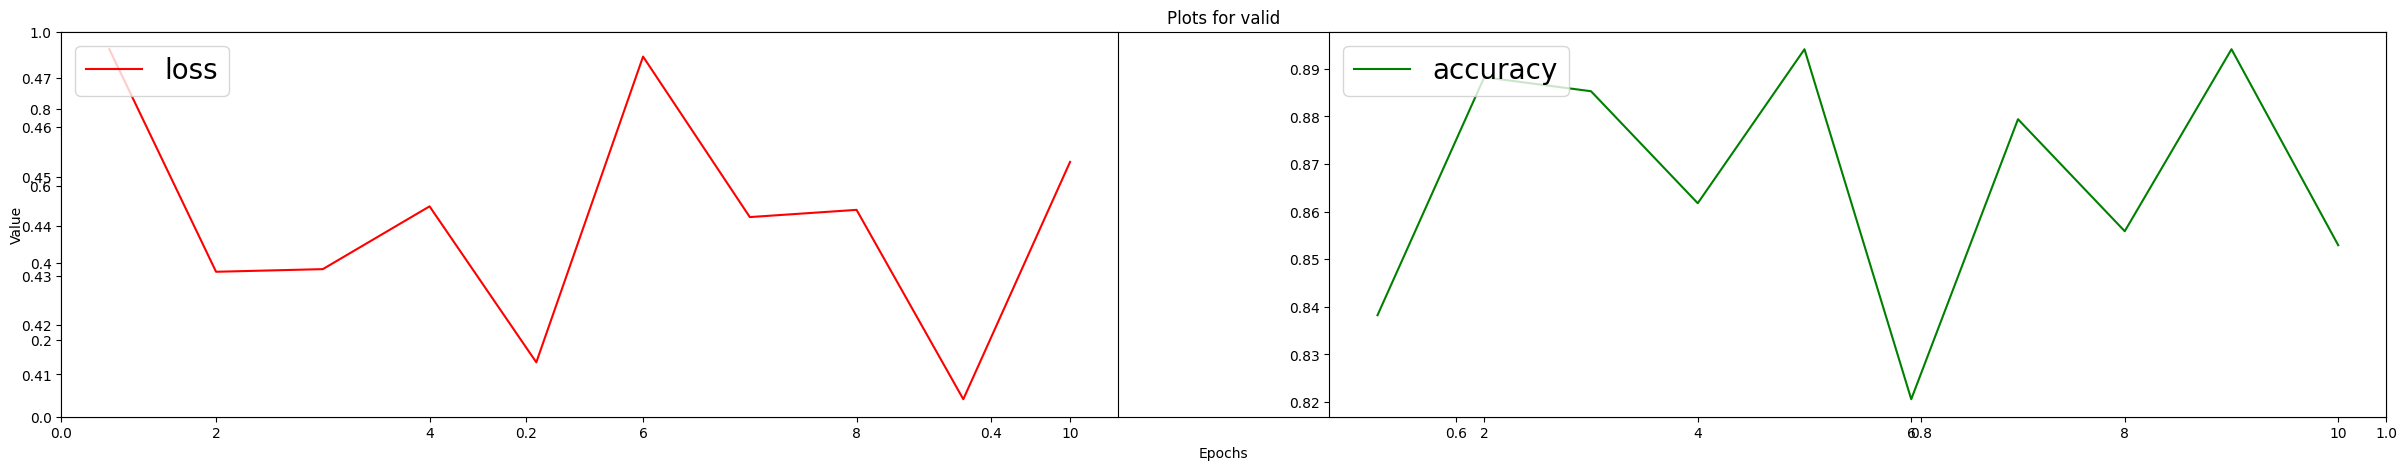

In [103]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.8871616125106812, train loss : 0.421381413936615
Epoch : 1, val_accuracy : 0.9055555462837219, val_loss : 0.40186452865600586
Epoch : 2, train accuracy : 0.8918914794921875, train loss : 0.4162273705005646
Epoch : 2, val_accuracy : 0.8944444060325623, val_loss : 0.4118197560310364
Epoch : 3, train accuracy : 0.8972968459129333, train loss : 0.41156068444252014
Epoch : 3, val_accuracy : 0.9277777671813965, val_loss : 0.38470005989074707
Epoch : 4, train accuracy : 0.9077696800231934, train loss : 0.39884909987449646
Epoch : 4, val_accuracy : 0.9166666269302368, val_loss : 0.4058495759963989
Epoch : 5, train accuracy : 0.8847968578338623, train loss : 0.42009106278419495
Epoch : 5, val_accuracy : 0.9333332777023315, val_loss : 0.3824176788330078
Epoch : 6, train accuracy : 0.8783778548240662, train loss : 0.4265822768211365
Epoch : 6, val_accuracy : 0.9111111760139465, val_loss : 0.3967769742012024
Epoch : 7, train accura

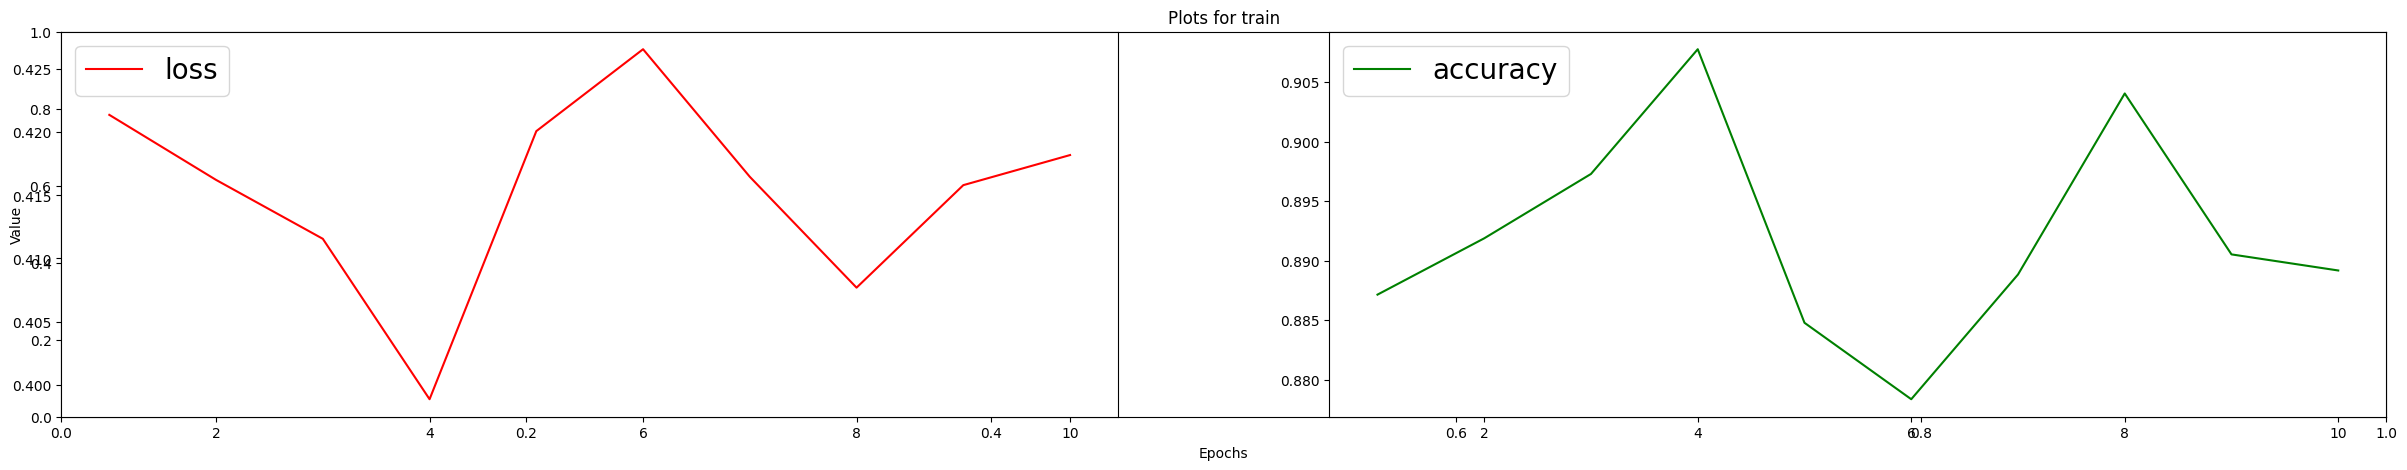

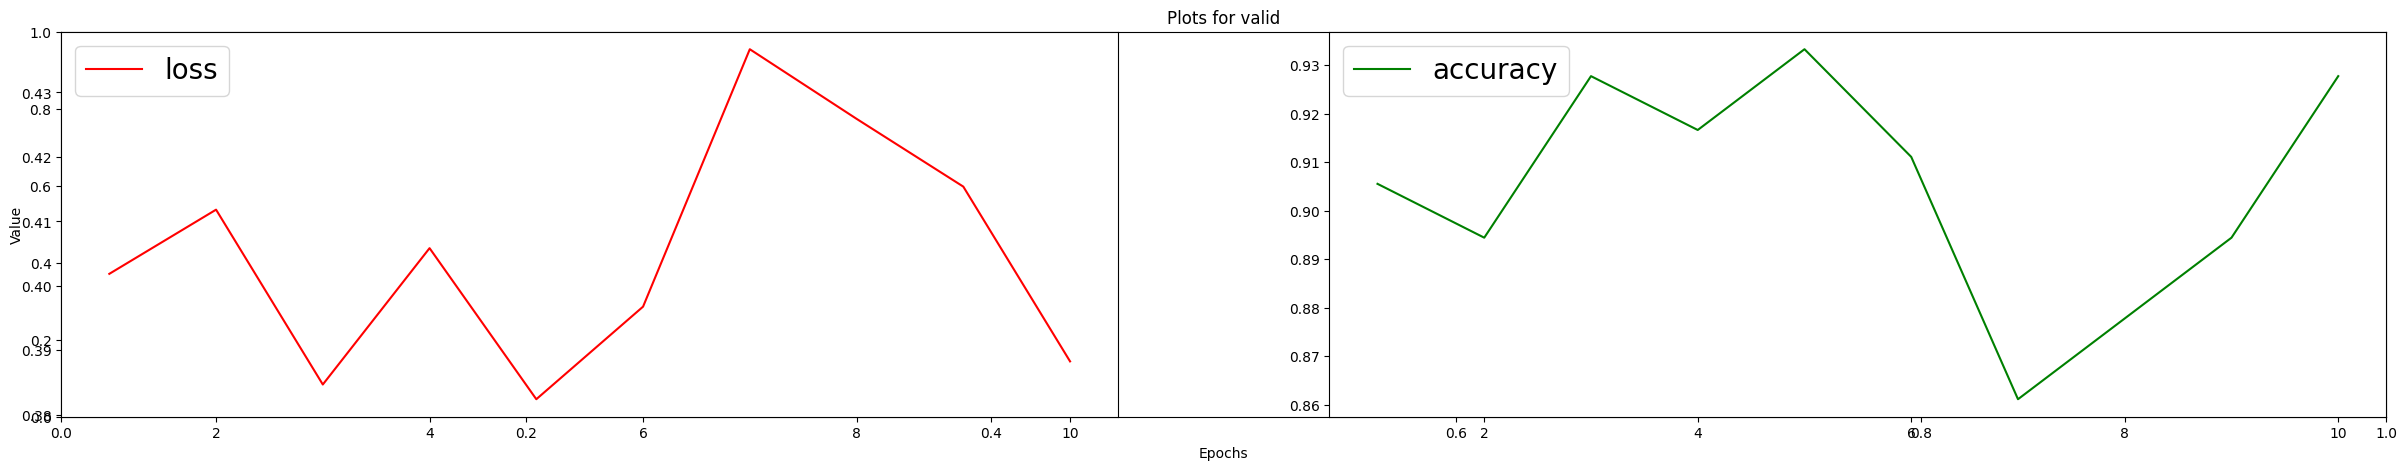

In [107]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.8996617197990417, train loss : 0.412426620721817
Epoch : 1, val_accuracy : 0.949999988079071, val_loss : 0.37626710534095764
Epoch : 2, train accuracy : 0.9077697396278381, train loss : 0.4037555754184723
Epoch : 2, val_accuracy : 0.9166666269302368, val_loss : 0.3926144540309906
Epoch : 3, train accuracy : 0.900337278842926, train loss : 0.4081141948699951
Epoch : 3, val_accuracy : 0.9555554986000061, val_loss : 0.354912668466568
Epoch : 4, train accuracy : 0.9037157893180847, train loss : 0.4048156142234802
Epoch : 4, val_accuracy : 0.9222221970558167, val_loss : 0.3948090672492981
Epoch : 5, train accuracy : 0.9185805916786194, train loss : 0.3945399820804596
Epoch : 5, val_accuracy : 0.8944444060325623, val_loss : 0.41972172260284424
Epoch : 6, train accuracy : 0.9013509154319763, train loss : 0.4076903462409973
Epoch : 6, val_accuracy : 0.9222221374511719, val_loss : 0.3930578827857971
Epoch : 7, train accuracy : 

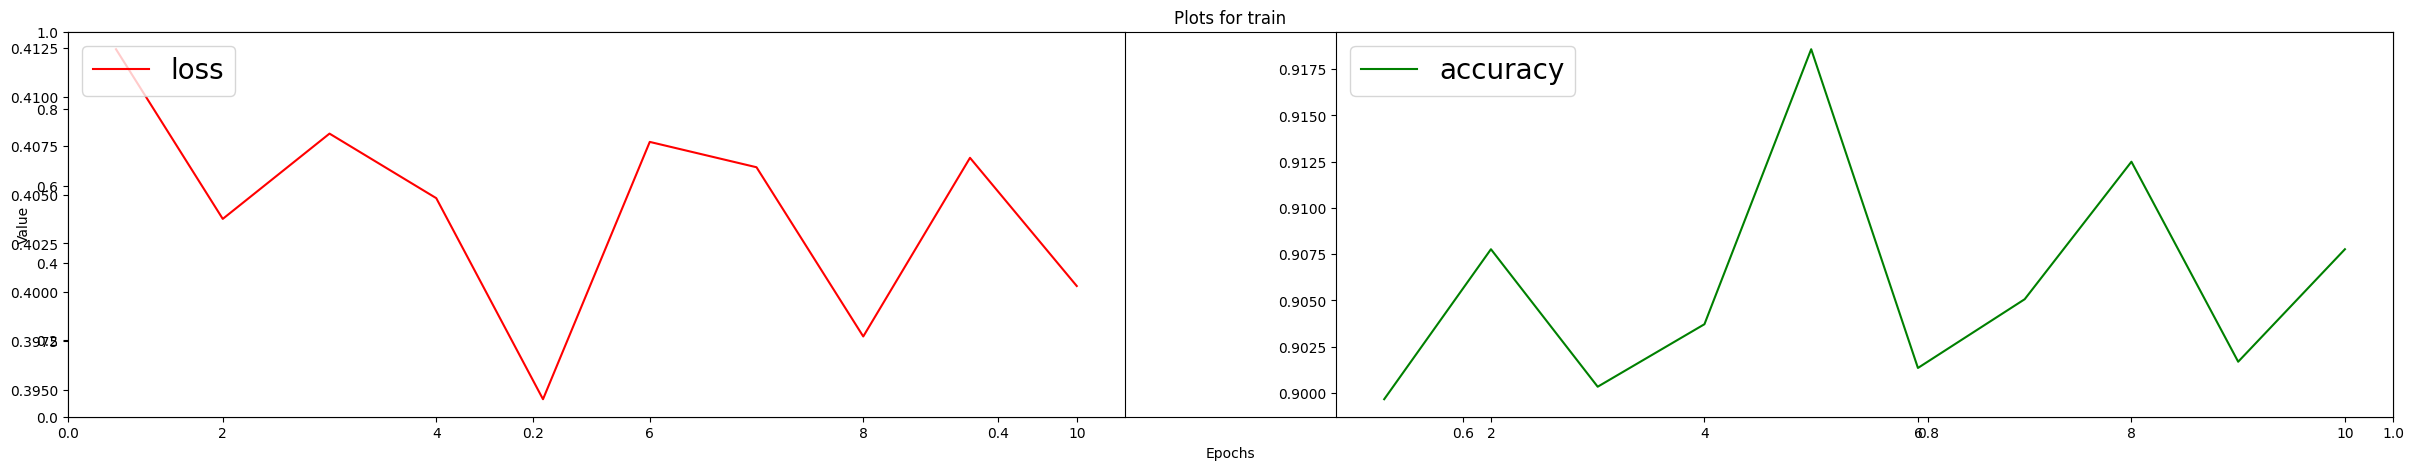

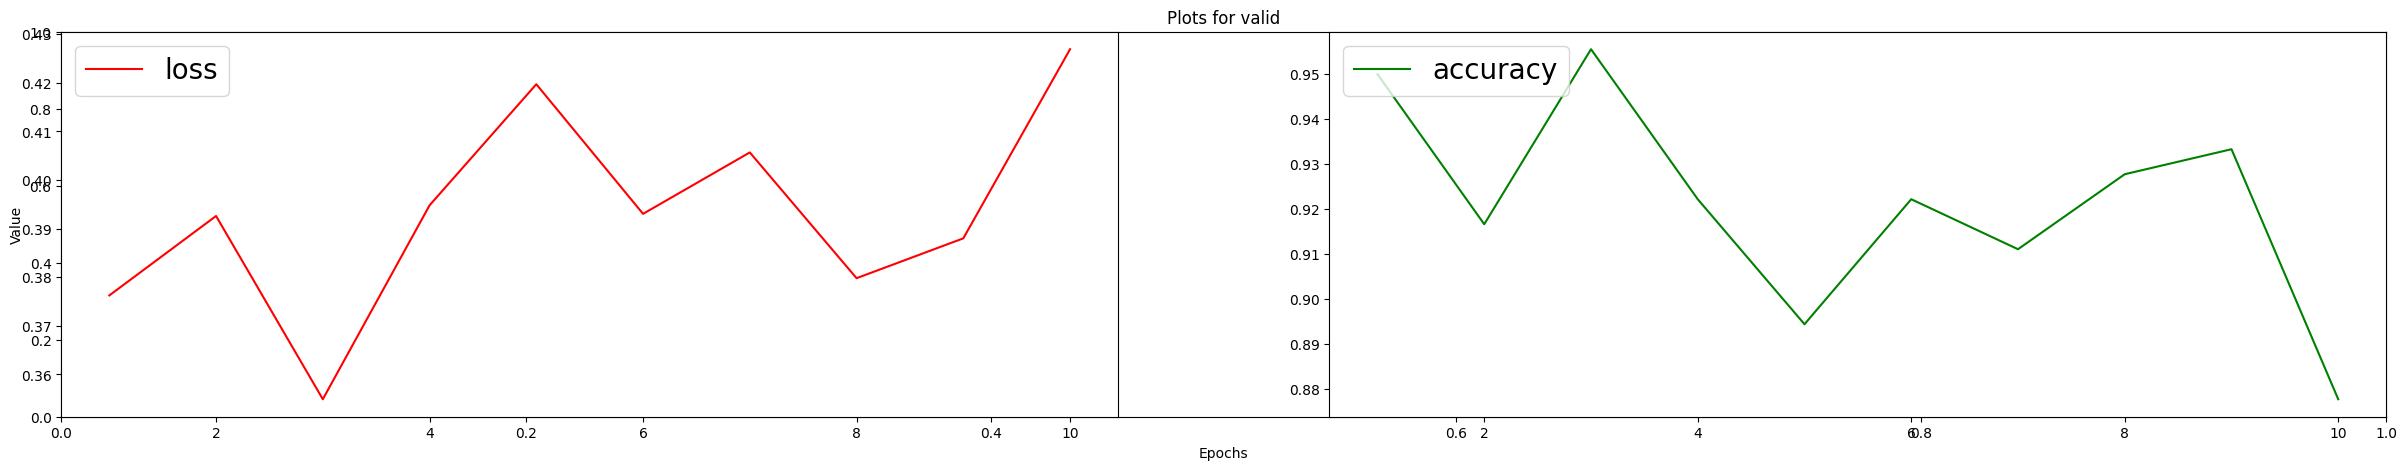

In [108]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9030400514602661, train loss : 0.405356228351593
Epoch : 1, val_accuracy : 0.8555554747581482, val_loss : 0.4511469900608063
Epoch : 2, train accuracy : 0.8824320435523987, train loss : 0.4237592816352844
Epoch : 2, val_accuracy : 0.9777777194976807, val_loss : 0.34709376096725464
Epoch : 3, train accuracy : 0.9020266532897949, train loss : 0.4066386818885803
Epoch : 3, val_accuracy : 0.9333332777023315, val_loss : 0.38956570625305176
Epoch : 4, train accuracy : 0.9074319005012512, train loss : 0.4022900462150574
Epoch : 4, val_accuracy : 0.9111111760139465, val_loss : 0.4025866687297821
Epoch : 5, train accuracy : 0.8905400037765503, train loss : 0.41670823097229004
Epoch : 5, val_accuracy : 0.8722223043441772, val_loss : 0.4282257556915283
Epoch : 6, train accuracy : 0.9033778309822083, train loss : 0.40768367052078247
Epoch : 6, val_accuracy : 0.8777777552604675, val_loss : 0.4254579246044159
Epoch : 7, train accura

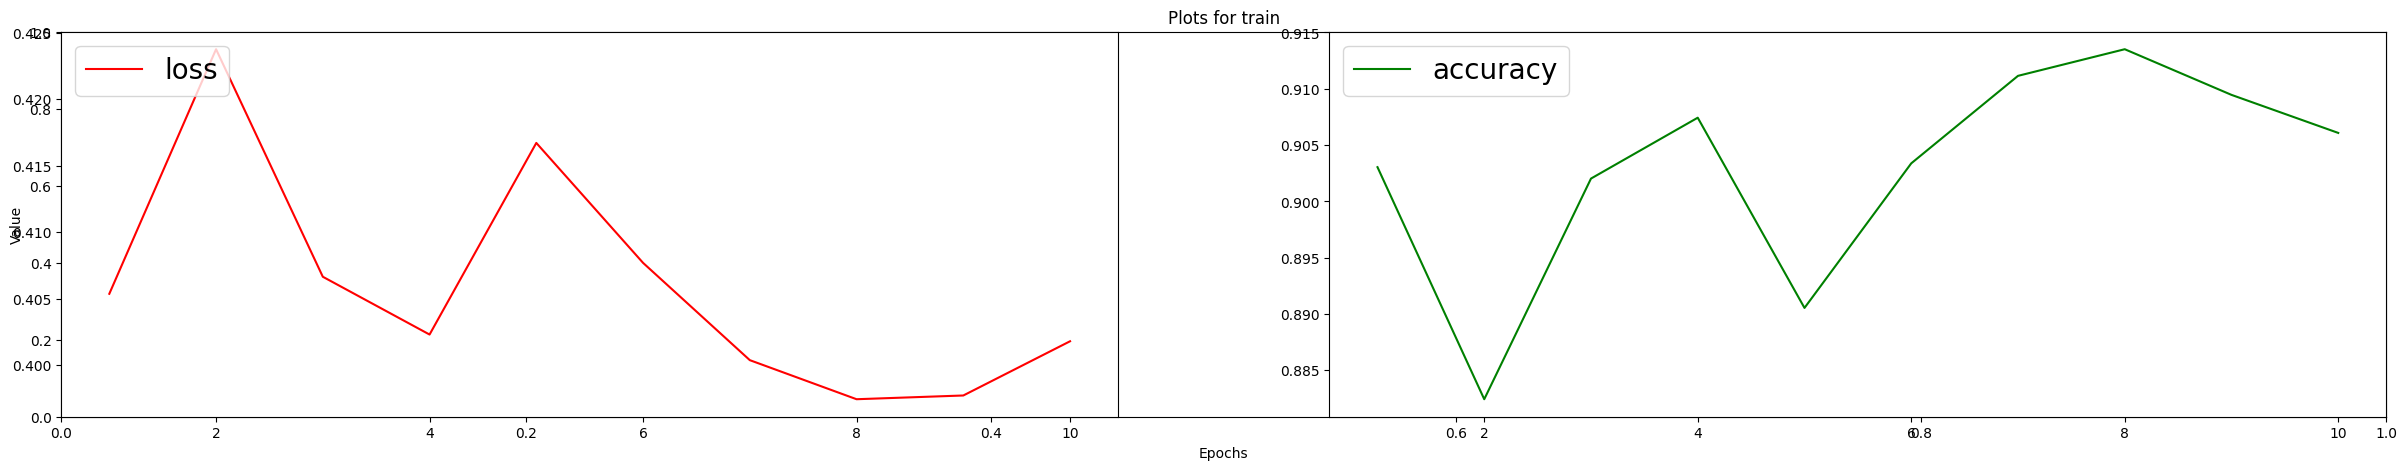

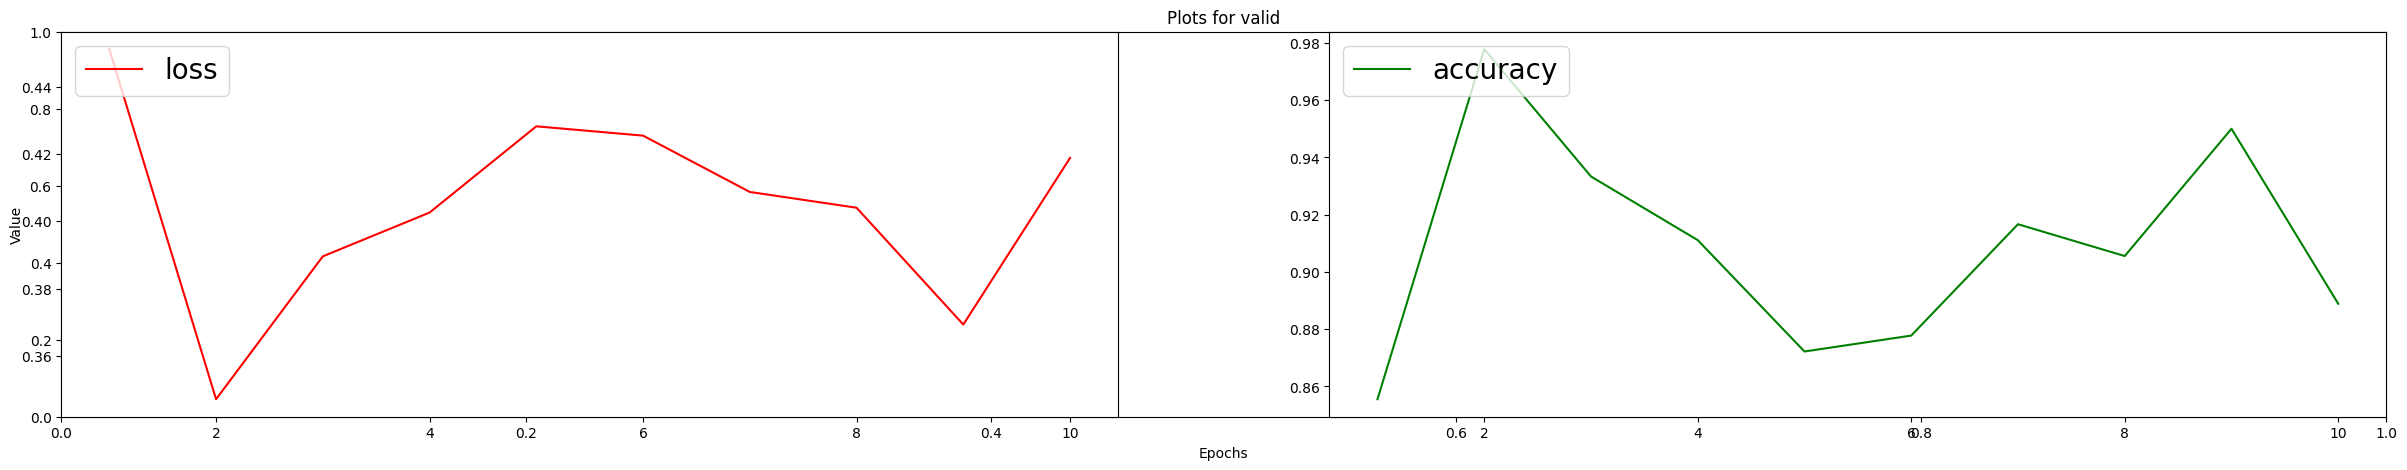

In [109]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.920296311378479, train loss : 0.3903968632221222
Epoch : 1, val_accuracy : 0.8942857384681702, val_loss : 0.41540443897247314
Epoch : 2, train accuracy : 0.9068148136138916, train loss : 0.400400310754776
Epoch : 2, val_accuracy : 0.9221428632736206, val_loss : 0.3931457996368408
Epoch : 3, train accuracy : 0.9064443707466125, train loss : 0.40143975615501404
Epoch : 3, val_accuracy : 0.9171428680419922, val_loss : 0.3810461163520813
Epoch : 4, train accuracy : 0.9121481776237488, train loss : 0.3963738679885864
Epoch : 4, val_accuracy : 0.881428599357605, val_loss : 0.4176129996776581
Epoch : 5, train accuracy : 0.9112591743469238, train loss : 0.3983474373817444
Epoch : 5, val_accuracy : 0.8714286088943481, val_loss : 0.4224188029766083
Epoch : 6, train accuracy : 0.9044443368911743, train loss : 0.40440356731414795
Epoch : 6, val_accuracy : 0.912142813205719, val_loss : 0.3901329040527344
Epoch : 7, train accuracy : 

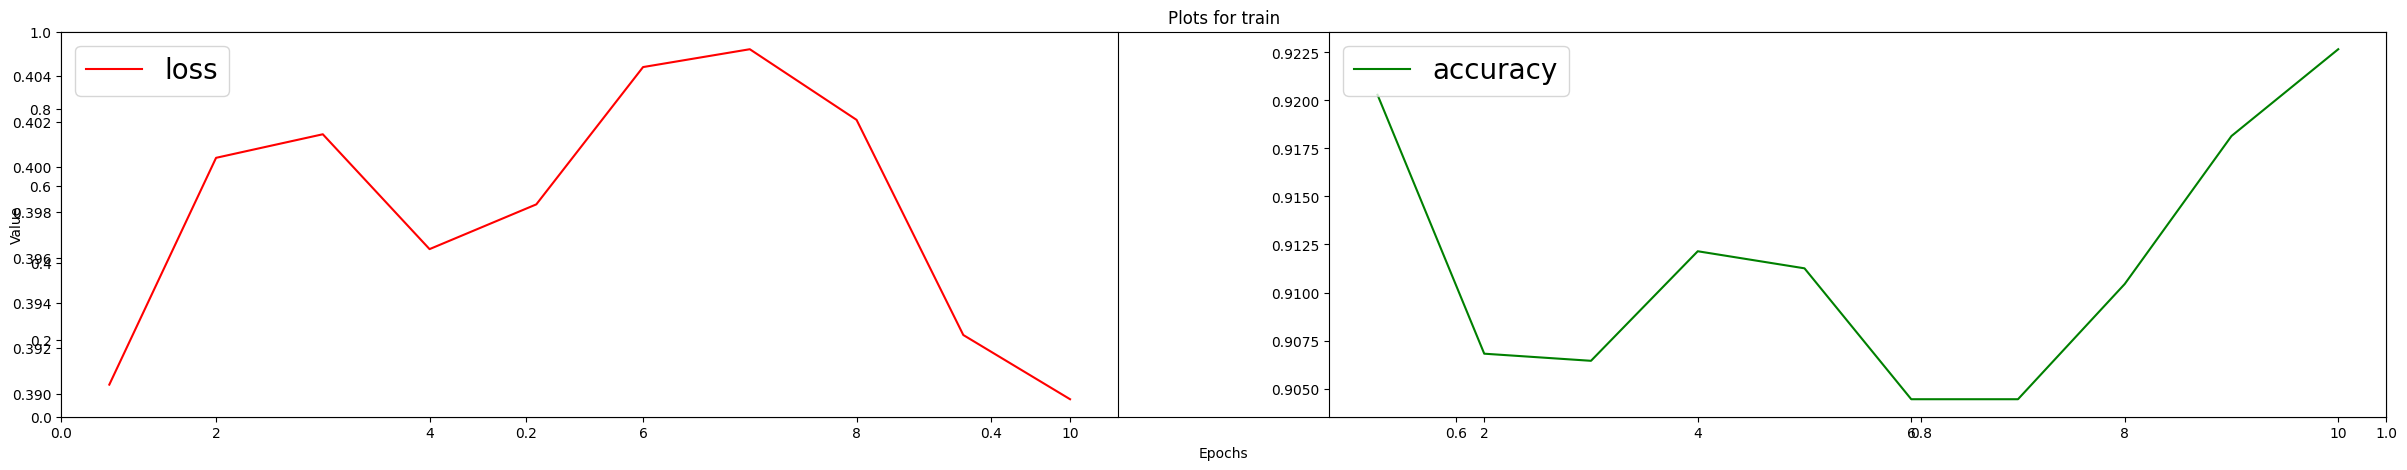

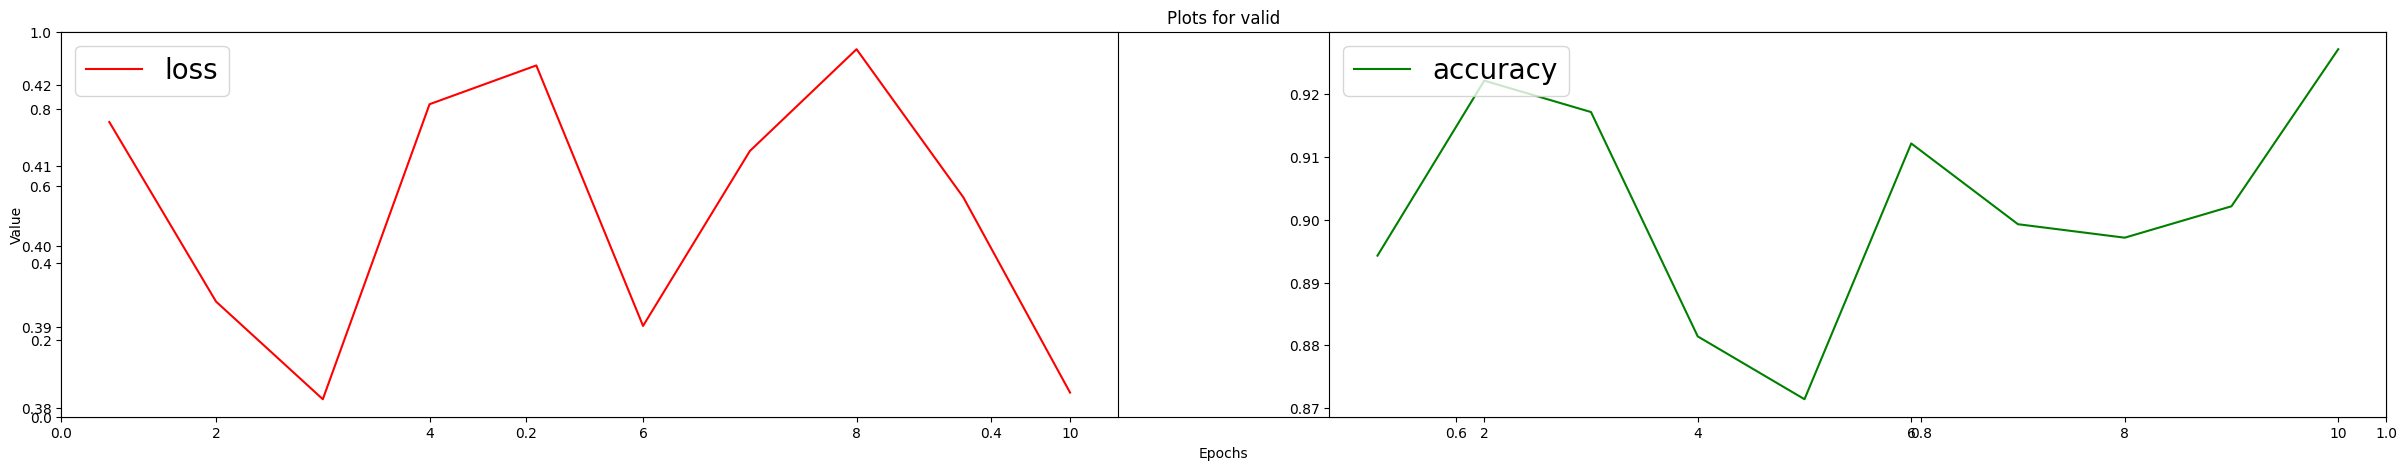

In [110]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.9179258346557617, train loss : 0.3910472095012665
Epoch : 1, val_accuracy : 0.9214285612106323, val_loss : 0.3861345052719116
Epoch : 2, train accuracy : 0.9281479716300964, train loss : 0.38111966848373413
Epoch : 2, val_accuracy : 0.9221428036689758, val_loss : 0.39106956124305725
Epoch : 3, train accuracy : 0.9289628863334656, train loss : 0.38178518414497375
Epoch : 3, val_accuracy : 0.9092857241630554, val_loss : 0.39935269951820374
Epoch : 4, train accuracy : 0.9254814386367798, train loss : 0.3859677016735077
Epoch : 4, val_accuracy : 0.9221428632736206, val_loss : 0.3869830369949341
Epoch : 5, train accuracy : 0.9194815158843994, train loss : 0.38863056898117065
Epoch : 5, val_accuracy : 0.9550000429153442, val_loss : 0.3560681641101837
Epoch : 6, train accuracy : 0.9359999299049377, train loss : 0.3749496042728424
Epoch : 6, val_accuracy : 0.9421428442001343, val_loss : 0.3716337978839874
Epoch : 7, train accu

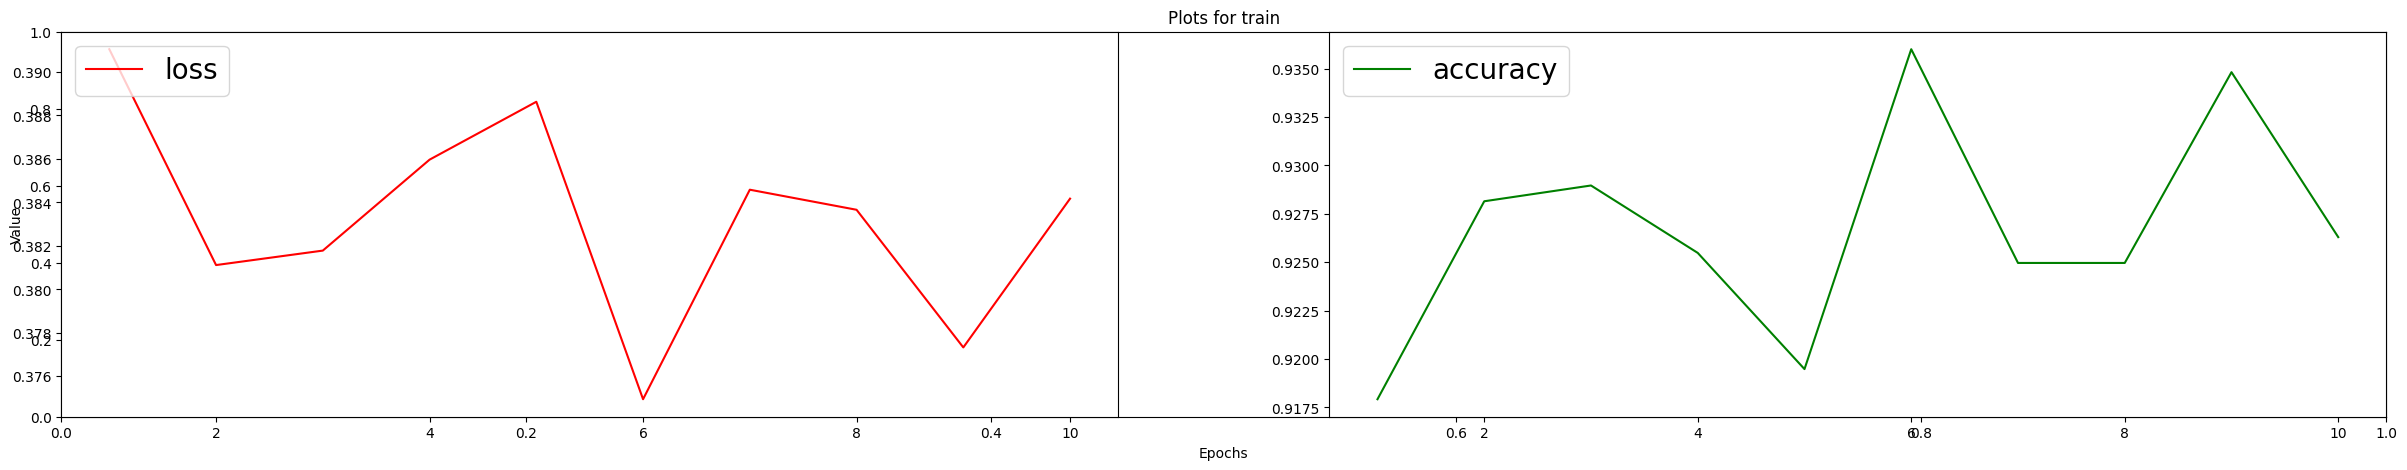

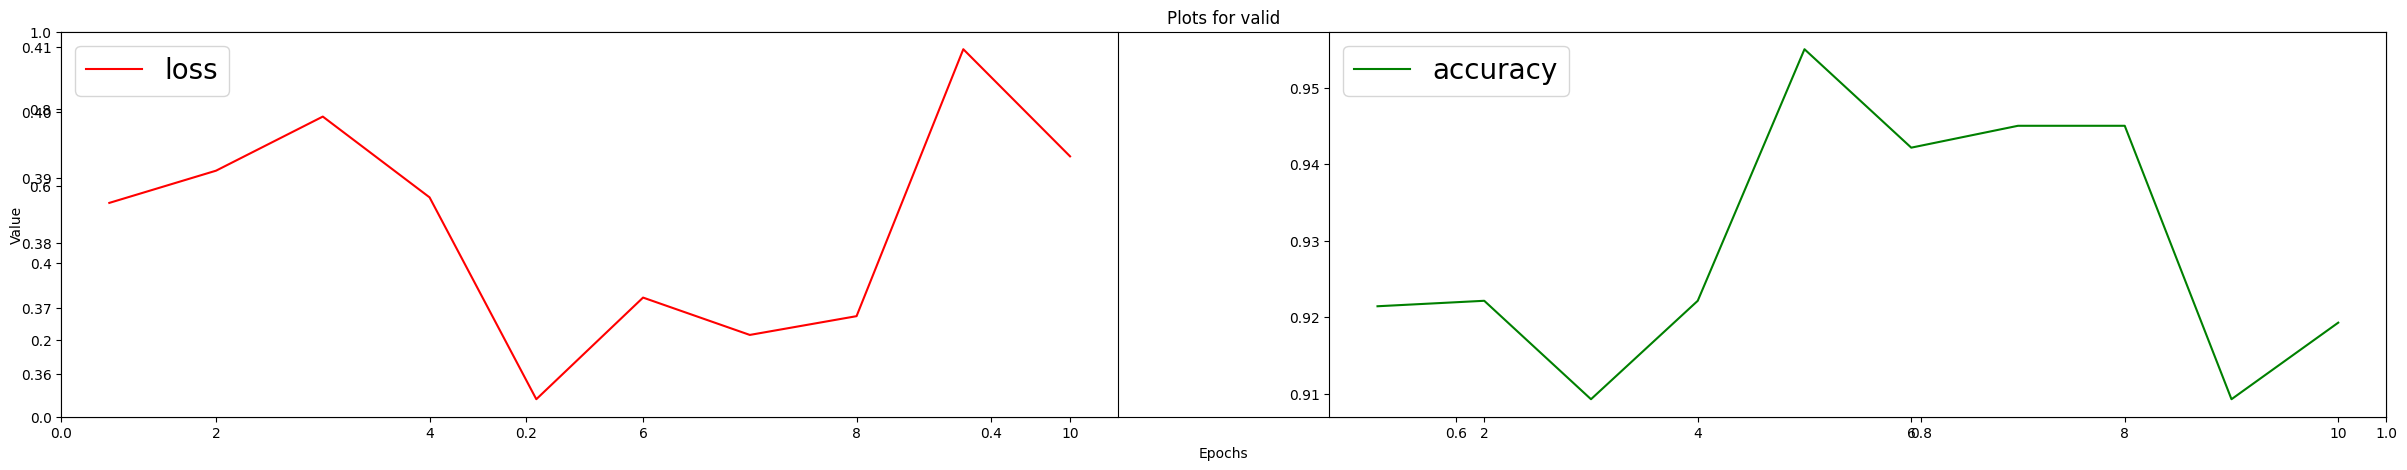

In [111]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.9314814805984497, train loss : 0.38327762484550476
Epoch : 1, val_accuracy : 0.9421428442001343, val_loss : 0.37274259328842163
Epoch : 2, train accuracy : 0.9144443869590759, train loss : 0.3940272331237793
Epoch : 2, val_accuracy : 0.9121428728103638, val_loss : 0.4061283469200134
Epoch : 3, train accuracy : 0.9271110892295837, train loss : 0.3846302032470703
Epoch : 3, val_accuracy : 0.8914285898208618, val_loss : 0.4155283570289612
Epoch : 4, train accuracy : 0.9181480407714844, train loss : 0.38584333658218384
Epoch : 4, val_accuracy : 0.8992857336997986, val_loss : 0.4025845527648926
Epoch : 5, train accuracy : 0.9148889780044556, train loss : 0.3889458179473877
Epoch : 5, val_accuracy : 0.9371428489685059, val_loss : 0.38134709000587463
Epoch : 6, train accuracy : 0.9168148040771484, train loss : 0.39264750480651855
Epoch : 6, val_accuracy : 0.942142903804779, val_loss : 0.3789554536342621
Epoch : 7, train accur

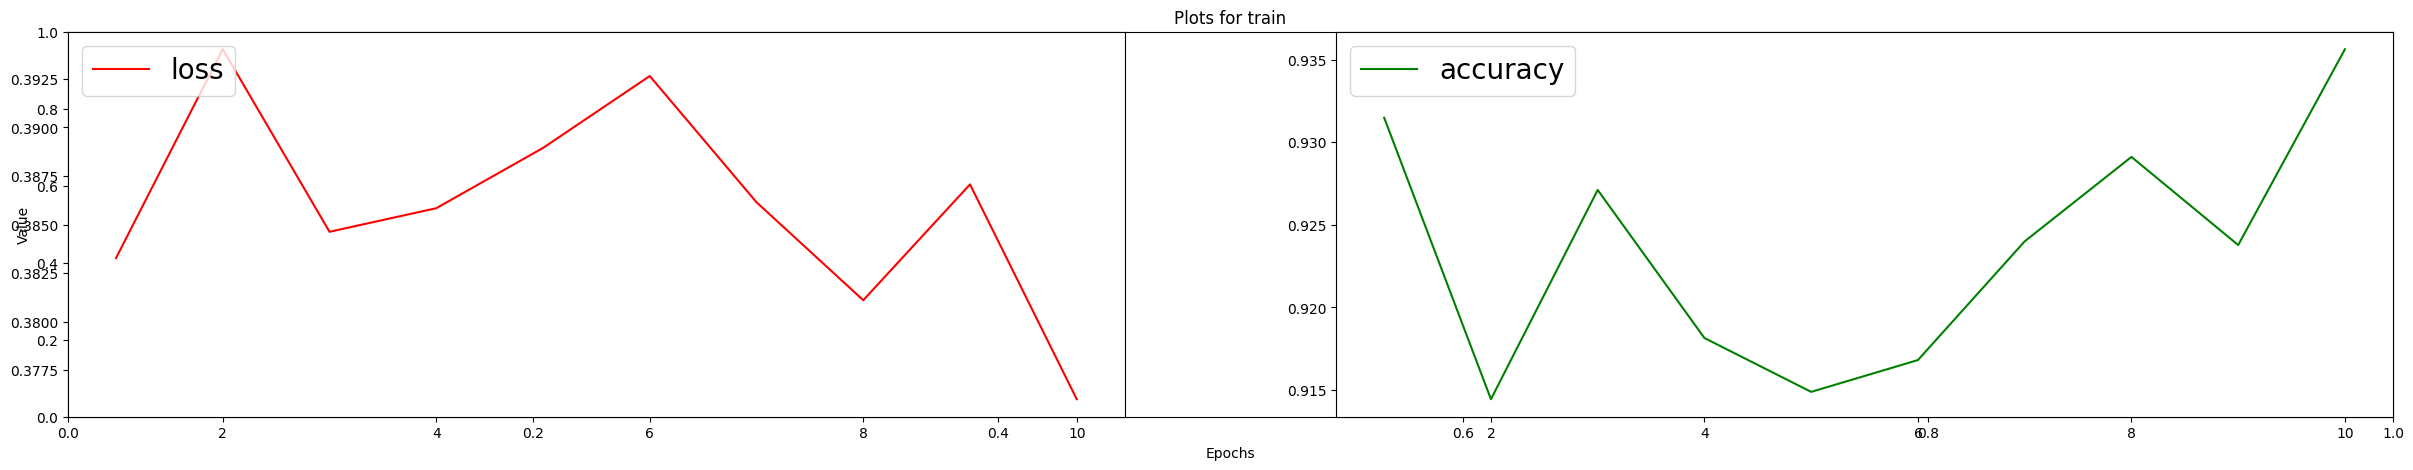

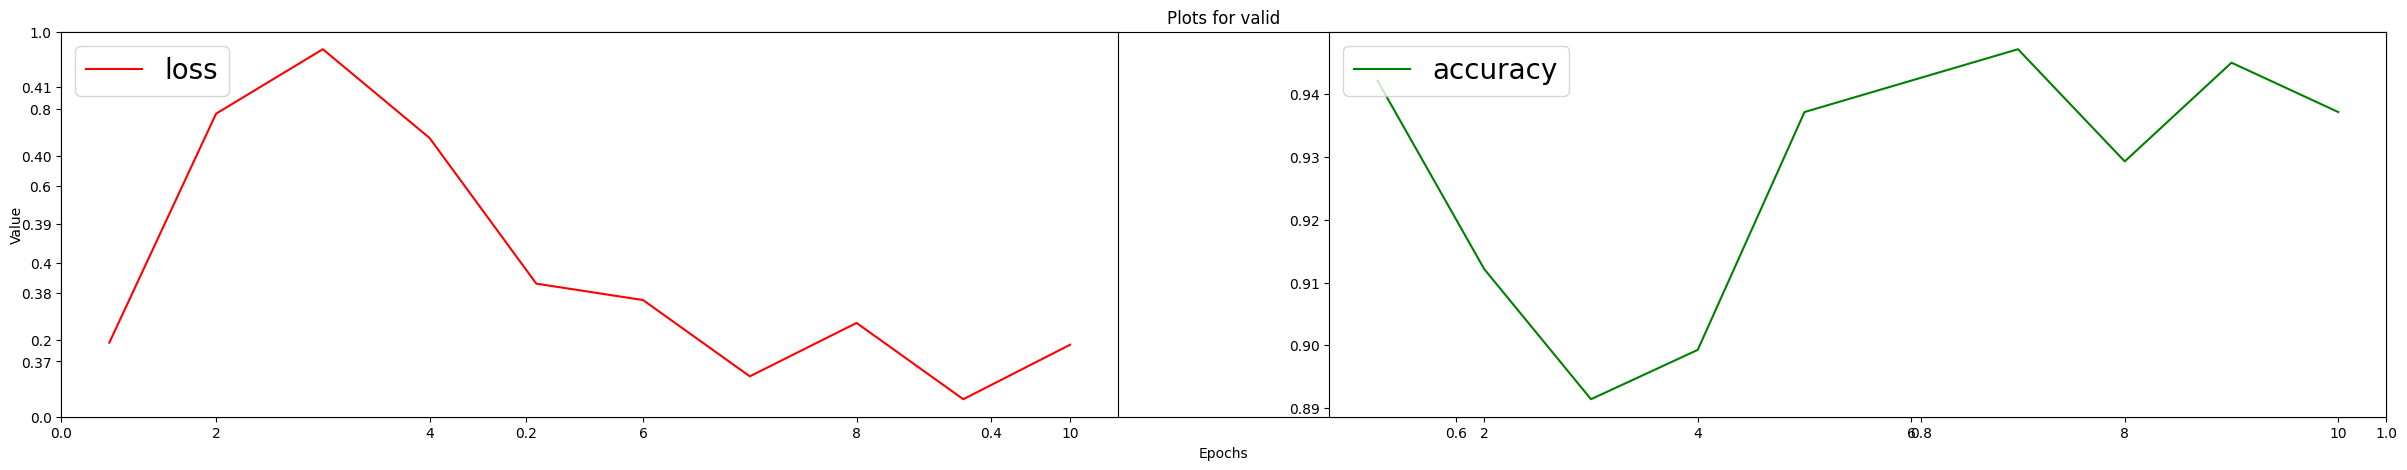

In [112]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

In [124]:
rose_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(list(fileid), preds_list))

idx = list(map(lambda x: x[0], rose_probs))
prob = list(map(lambda x: x[1], rose_probs))

submission = pd.DataFrame({'id': idx, 'label': prob})

submission

id     label
0     43  0.542643
1    100  0.731058
2     35  0.731058
3    140  0.268944
4    175  0.296896
..   ...       ...
199    7  0.731057
200  193  0.270142
201  103  0.268941
202   80  0.269971
203   73  0.731042

[204 rows x 2 columns]

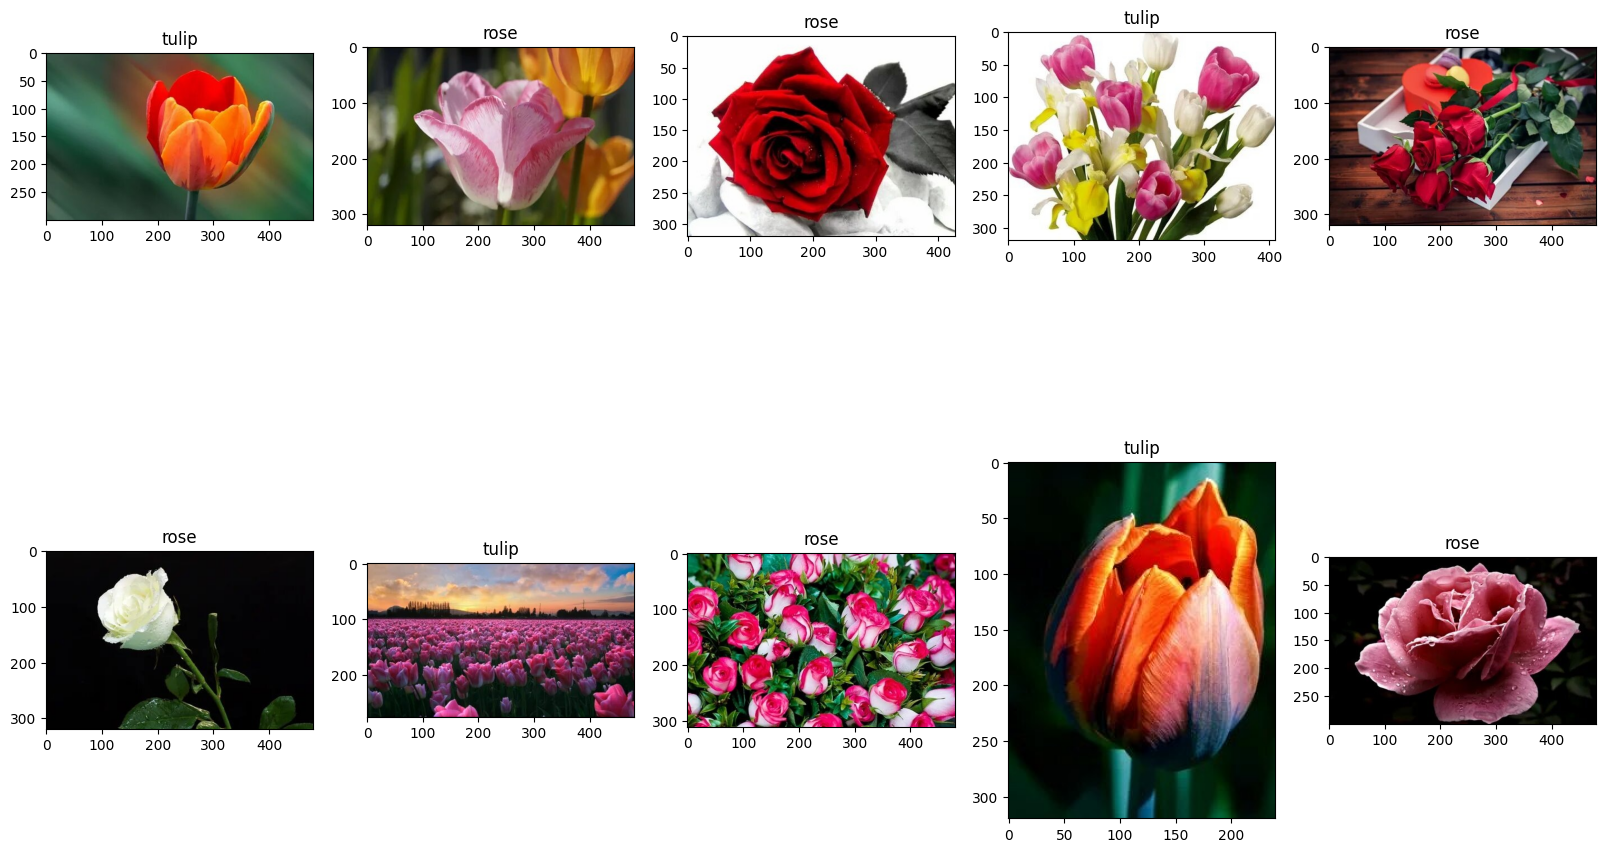

In [116]:

class_ = {0: 'tulip', 1: 'rose'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(path_test, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)

In [117]:
torch.save(model.state_dict(), 'my_model.pt')

In [118]:
model = CNN()
model.load_state_dict(torch.load('my_model.pt'))

<All keys matched successfully>

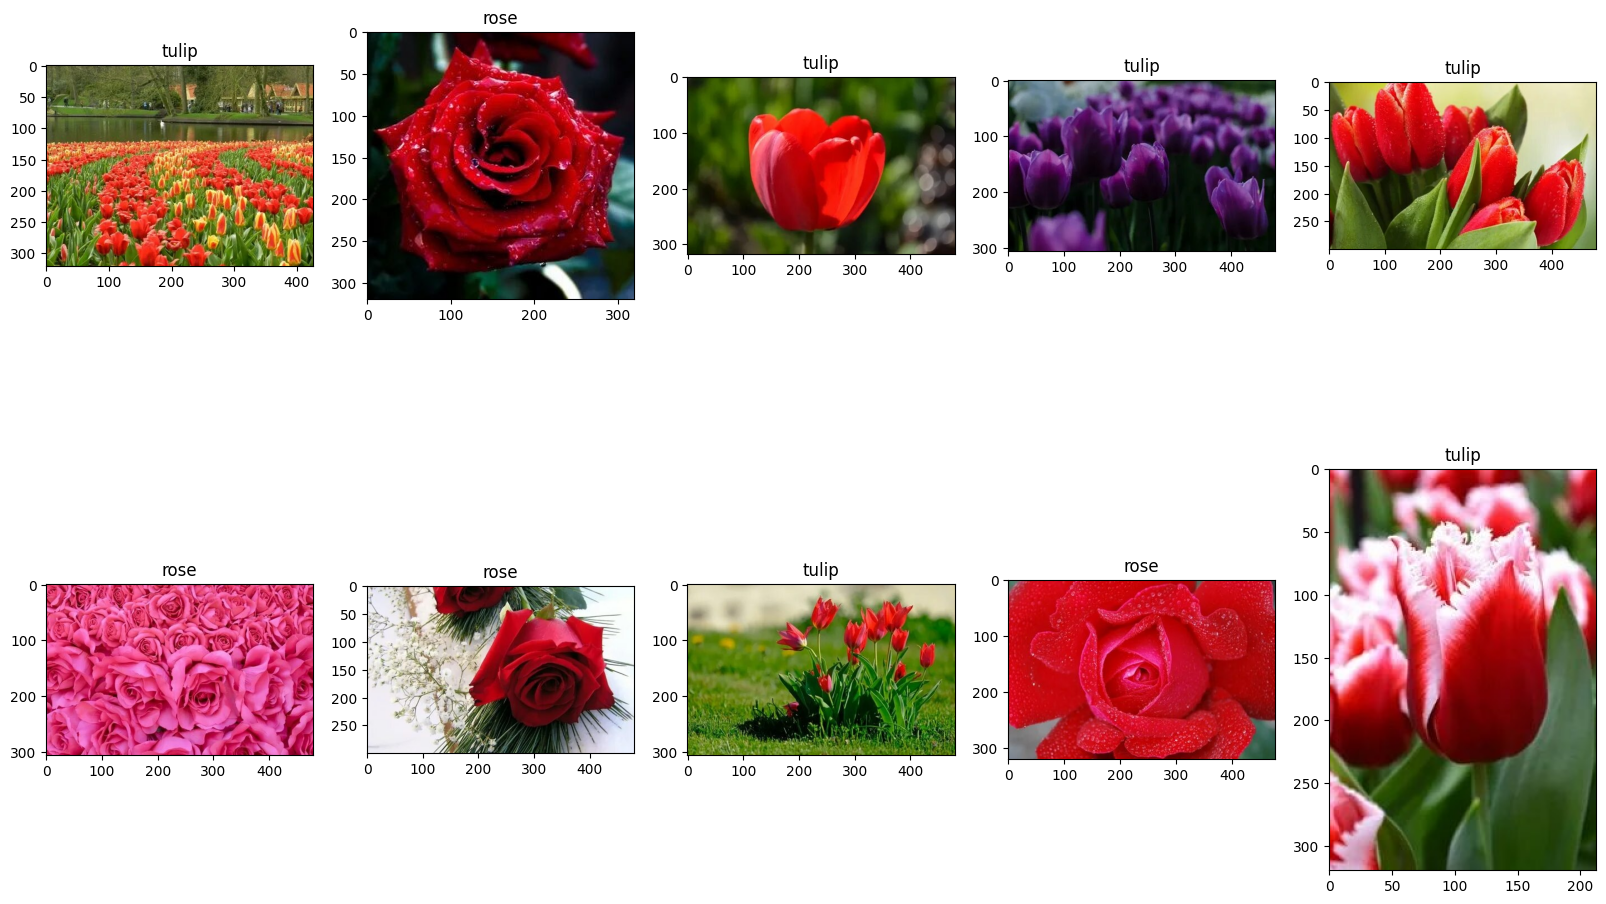

In [120]:
rose_probs =[]
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(list(fileid), preds_list))

idx = list(map(lambda x: x[0], rose_probs))
prob = list(map(lambda x: x[1], rose_probs))

submission = pd.DataFrame({'id': idx, 'label': prob})

class_ = {0: 'tulip', 1: 'rose'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(path_test, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)